In [1]:
"""
@file mnist_example.ipynb
@author Ryan Missel

This notebook runs through an example of training a simple 1-layer MNIST classifier
with the meta-prior and visualizing the meta-space following it.
"""
import math
import time
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as func

from tqdm.notebook import tqdm
from scipy.stats import entropy
from sklearn.manifold import TSNE
from IPython.display import clear_output
from torch.distributions import Normal, kl_divergence as kl
from metaprior.metautils import get_act, plot_metaspace_mean, plot_metaspace_var, plot_weight_correlations

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
class OldNet(nn.Module):
    def __init__(self, layer_sizes=[1, 100, 1], mean=False, local=False, activation='linear', hyperprior_dim=32, code_dim=2):
        super(OldNet, self).__init__()
        self.input_dim = layer_sizes[0]
        self.layer_sizes = layer_sizes
        self.code_dim = code_dim

        self.priorlog = math.log(0.1)
        
        self.local = local
        self.mean = mean

        self.acts = [get_act('relu') if i < len(layer_sizes) - 2 else get_act(activation)
                         for i in range(len(layer_sizes) - 1)]
        
        """ Codes """
        self.code_mu = nn.ParameterList([])
        self.code_var = nn.ParameterList([])
        for lidx in range(len(layer_sizes)):
            code = torch.nn.Parameter(
                torch.zeros([layer_sizes[lidx], self.code_dim]),
                requires_grad=True
            )
            self.code_mu.append(code)
        
        for lidx in range(len(layer_sizes)):
            code = torch.nn.Parameter(
                torch.ones([layer_sizes[lidx], self.code_dim]),
                requires_grad=True
            )
            self.code_var.append(code)
        
        self.codes = [1, 2, 3, 4]
        
        self.hyperprior = nn.Sequential(
            nn.Linear(self.code_dim * 2, 36),
            nn.ReLU(),
            nn.Linear(36, 36),
            nn.ReLU(),
            nn.Linear(36, 1),
        )
        
        self.reset_parameters()
    
    def reset_parameters(self):
        for lidx in range(len(self.layer_sizes)):
            # Initialization method of Adv-BNN
            stdv = 1. / math.sqrt(self.code_mu[lidx].size(1))
            self.code_mu[lidx].data.uniform_(-stdv, stdv)
            self.code_var[lidx].data.fill_(self.priorlog)
    
    def kl_term(self):
        mus = torch.cat([cmu.view([-1]) for cmu in self.code_mu])
        var = torch.cat([cvar.view([-1]) for cvar in self.code_var])

        kl = self.priorlog - var + (torch.exp(var) ** 2 + (mus - 0) ** 2) / (2 * math.exp(self.priorlog) ** 2) - 0.5
     
        return kl.sum()
    
    def forward(self, x):
        # Sample the codes array
        codes = [
            self.code_mu[i] + torch.randn_like(self.code_mu[i]) * self.code_var[i].exp()
            for i in range(len(self.layer_sizes))
        ]
        
        for idx in range(len(self.layer_sizes) - 1):
            # Generate weight codes
            temp = codes[idx].unsqueeze(1).repeat(1, self.layer_sizes[idx + 1], 1).view([-1, self.code_dim])
            temp2 = codes[idx + 1].unsqueeze(0).repeat(self.layer_sizes[idx], 1, 1).view([-1, self.code_dim])
            weight_code = torch.cat((temp2, temp), dim=1)

            # Generate bias codes (concatenation is just with a zeros vector)
            bias_code = torch.cat((torch.zeros_like(codes[idx + 1]), codes[idx + 1]), dim=1)
            
            # Get weights and biases out
            w = self.hyperprior(weight_code).view([self.layer_sizes[idx], self.layer_sizes[idx + 1]])
            b = self.hyperprior(bias_code).squeeze()
            
            # Apply layer with derived weights
            x = self.acts[idx](func.linear(x, w.T, b))
        
        return x


In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

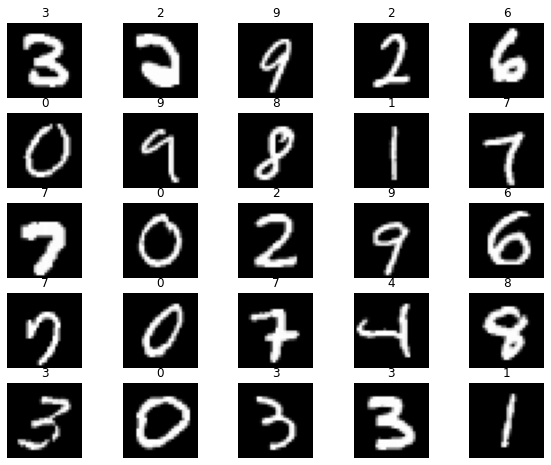

In [4]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
from torch.utils.data import DataLoader

trainloader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)

In [6]:
net = OldNet(layer_sizes=[784, 100, 10], code_dim=10)

lossf = nn.CrossEntropyLoss()
nll = nn.NLLLoss()

optim = torch.optim.Adam(net.parameters(), lr=0.01)

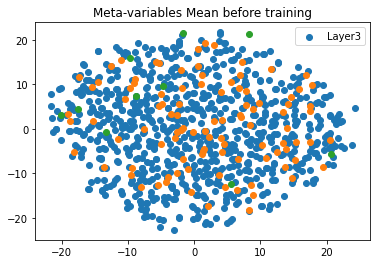

In [7]:
def plot_metaprior_tsne(net, train=True):
    show = True
    direct = './tsne'
    perplexity = 50
    lr = 500
    n_iter = 1000
    early_exaggeration = 12
    n_comp = 2

    # Define algorithm
    tsne = TSNE(n_components=n_comp, perplexity=perplexity, learning_rate=lr, n_iter=n_iter, early_exaggeration=early_exaggeration)

    # Fit on training data
#     print(torch.vstack(([m for m in net.code_mu])).shape)
    
    fitted = tsne.fit(torch.vstack(([m for m in net.code_mu])).detach().cpu().numpy())
#     print("Train set finished after {} iterations".format(fitted.n_iter))
    embedding = fitted.embedding_

#     print(embedding.shape)
    shapes = ((0, 784), (784, 884), (884, 894))
    for (s1, s2) in shapes:
        plt.scatter(embedding[s1:s2, 0], embedding[s1:s2, 1])

    plt.legend(('Layer{}'.format(i) for i in range(len(net.codes))))
    plt.title("Meta-variables Mean {} training".format("before" if train else "after"))
    plt.show()
    

plot_metaprior_tsne(net)

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [1/100] Train [CE: 2.3021 KLZ: 595.2398] Test [CE: 2.3016 ACC: 0.1135]


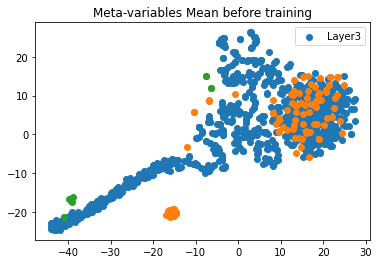

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [2/100] Train [CE: 2.3016 KLZ: 146.2647] Test [CE: 2.3015 ACC: 0.1140]


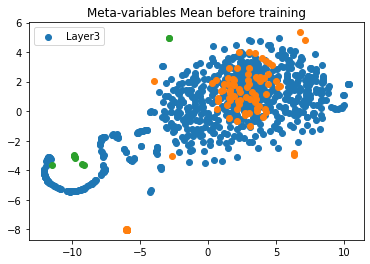

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [3/100] Train [CE: 2.3017 KLZ: 133.3853] Test [CE: 2.3017 ACC: 0.1135]


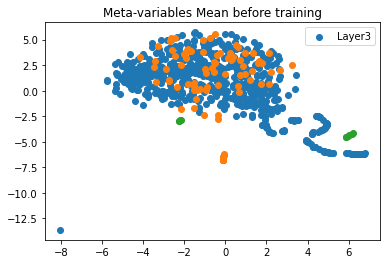

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [4/100] Train [CE: 2.3016 KLZ: 125.9173] Test [CE: 2.3011 ACC: 0.1135]


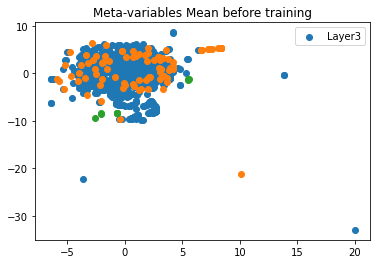

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [5/100] Train [CE: 2.3017 KLZ: 119.9139] Test [CE: 2.3015 ACC: 0.1135]


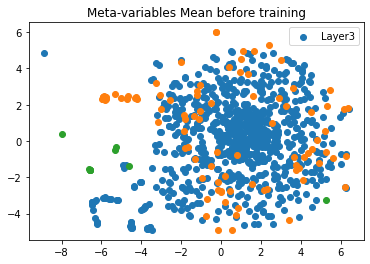

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [6/100] Train [CE: 2.3016 KLZ: 116.1622] Test [CE: 2.3014 ACC: 0.1135]


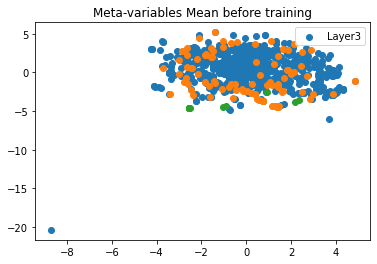

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [7/100] Train [CE: 2.3015 KLZ: 127.0140] Test [CE: 2.3010 ACC: 0.1135]


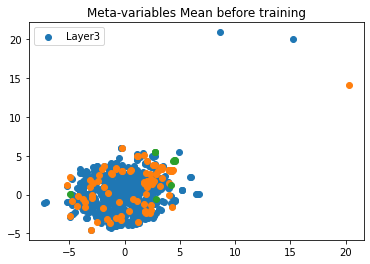

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [8/100] Train [CE: 2.3015 KLZ: 132.2814] Test [CE: 2.3013 ACC: 0.1135]


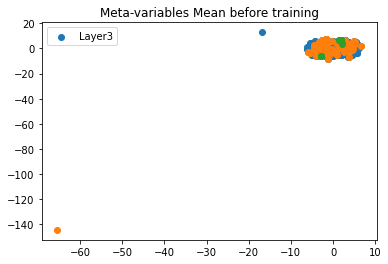

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [9/100] Train [CE: 2.3015 KLZ: 117.7042] Test [CE: 2.3015 ACC: 0.1135]


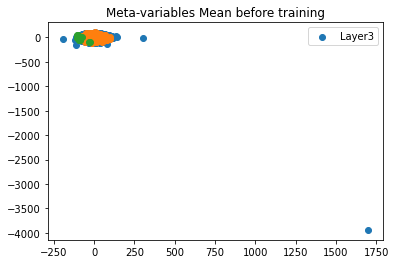

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [10/100] Train [CE: 2.3015 KLZ: 118.0883] Test [CE: 2.3012 ACC: 0.1135]


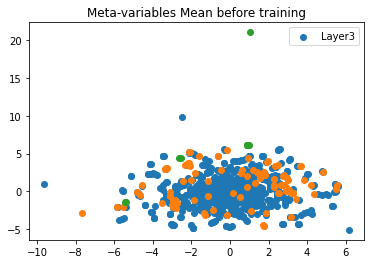

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [11/100] Train [CE: 2.3015 KLZ: 124.6755] Test [CE: 2.3012 ACC: 0.1135]


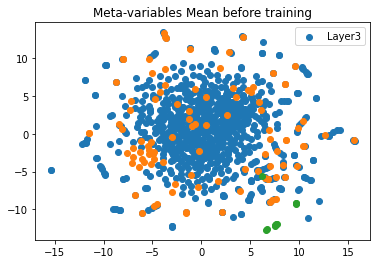

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [12/100] Train [CE: 2.3015 KLZ: 107.7625] Test [CE: 2.3012 ACC: 0.1135]


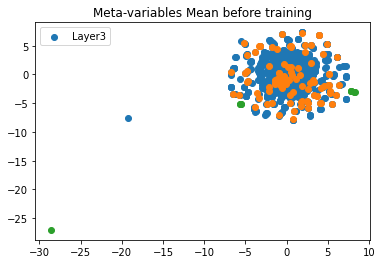

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [13/100] Train [CE: 2.3015 KLZ: 127.8382] Test [CE: 2.3013 ACC: 0.1135]


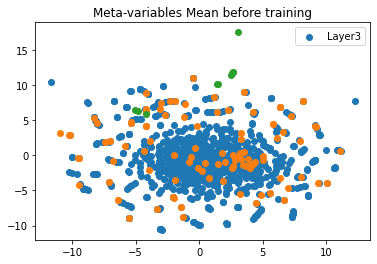

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [14/100] Train [CE: 2.3015 KLZ: 113.7071] Test [CE: 2.3013 ACC: 0.1135]


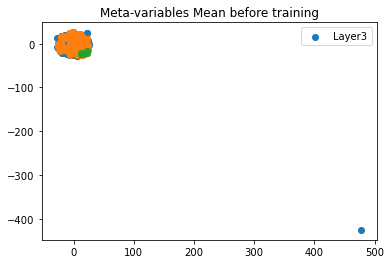

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


KeyboardInterrupt: 

In [8]:
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    net.train()
    epoch_celoss = 0
    epoch_klz = 0
    epoch_acc = 0
    num_batches = 0
    
    for (images, labels) in tqdm(trainloader):
        # Clear grads
        optim.zero_grad()    
        
        # Get prediction
        preds = net(images.flatten(1))        
#         celoss = 0
#         for _ in range(5):
#             preds = net(images.flatten(1)) 

#             cel = nll(preds, labels)
#             celoss += cel

#         celoss /= 5
        
        # Build loss
        celoss = lossf(preds, labels)
        klz = net.kl_term()
        loss = celoss + 0.000001 * klz
        
        # Perform step
        loss.backward()    
        optim.step()                

        epoch_celoss += celoss.item()
        epoch_klz += klz.item()
        num_batches += 1
        
    # Report loss, visualize tsne of meta-space
    net.eval()
    test_acc, test_loss = 0, 0
    test_batches, test_shape = 0, 0
    

    for (images, labels) in tqdm(testloader):
        # Predict
        preds = net(images.flatten(1))
        
        # Get losses
        celoss = lossf(preds, labels)
        
        test_loss += celoss.item()
        test_acc += sum(np.argmax(preds.detach().cpu().numpy(), axis=1) == labels.numpy())
        test_shape += labels.shape[0]
        test_batches += 1
        

    print('Epoch [{}/{}] Train [CE: {:.4f} KLZ: {:.4f}] Test [CE: {:.4f} ACC: {:.4f}]'
          .format(epoch + 1, num_epochs, epoch_celoss / num_batches, epoch_klz / num_batches,
                 test_loss / test_batches, test_acc / test_shape))
    plot_metaprior_tsne(net)


In [ ]:
# Generate a grid of points with distance h between them
cmap = cmap2d.SimplexColorMap([[-1, -1], [-1, 1], [1, -1], [1, 1]], [(0, 1, 0), (1, 1, 1), (0, 0, 1), (0, 0, 0)])

xx, yy = np.meshgrid(np.arange(-3, 3, 0.1), np.arange(-3, 3, 0.1))
dots = np.c_[xx.ravel(), yy.ravel()]
c = [cmap(d) for d in dots]

x = np.arange(28)
y = np.arange(28)
z = net.

In [ ]:
show = True
direct = './tsne'
perplexity = 50
lr = 500
n_iter = 1000
early_exaggeration = 12
n_comp = 1

# Define algorithm
tsne = TSNE(n_components=n_comp, perplexity=perplexity, learning_rate=lr, n_iter=n_iter, early_exaggeration=early_exaggeration)

# Fit on training data
fitted = tsne.fit(torch.vstack(([m for m in net.code_mu])).detach().cpu().numpy())
embedding = fitted.embedding_[0:784, :]

plt.scatter(range(784), embedding[:, 0], c=range(784))

plt.legend(('Layer{}'.format(i) for i in range(len(net.codes))))
plt.title("Meta-variables Mean {} training".format("before" if train else "after"))
plt.show()